# Infer ***mitochondria*** - part 5️⃣

--------------
OBJECTIVE: ✅ Infer sub-cellular component  ***mitochondria***  in order to understand interactome 

Dependencies:
The ***mitochondria***  inference rely on the ***cytosol*** mask

## preamble

1. imports
2. setup
3. get cytosol mask
4. infer mitochondria
    * pre-processing
    * core processing
    * post processing
5. export mitochondria



## IMPORTS

In [11]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

from typing import Optional, Dict

import numpy as np

from aicssegmentation.core.utils import size_filter
from aicssegmentation.core.MO_threshold import MO

from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari
### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.core.file_io import (read_czi_image, 
                                         read_ome_image,
                                         list_image_files, 
                                         import_inferred_organelle, 
                                         export_inferred_organelle)

from infer_subc_2d.core.img import *
from infer_subc_2d.organelles import fixed_infer_cellmask_fromaggr_MCZ, fixed_infer_nuclei, infer_cytoplasm

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [13]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [14]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK



In [15]:

cytoplasm_mask = import_inferred_organelle("cytosol", meta_dict, out_data_path)

if cytoplasm_mask is None:
    nuclei =  fixed_infer_nuclei(img_data) 
    cellmask = fixed_infer_cellmask_fromaggr_MCZ(img_data, nuclei)
    nucleus_obj =  apply_mask(nuclei, cellmask) 
    cytoplasm_mask =  infer_cytoplasm(cellmask, nucleus_obj, erode_nuclei=False) 
    out_file_n = export_inferred_organelle(cytoplasm_mask, "cytosol", meta_dict, out_data_path)
    print(f"calculated cytosol mask. wrote {out_file_n}")
else:
    print(f"loaded cytosol mask from {out_data_path}")


loaded cytosol mask from /Users/ahenrie/Projects/Imaging/data/out


---------------------

## infer ***mitochondria***

## summary of steps (Workflow #1 & #2)

INPUT
- channel  2
- cytosol mask

PRE-PROCESSING
-  smoothe / remove noise

CORE-PROCESSING
-  'vesselness' enhancement
-  threshold objects

- POST-PROCESSING
  - filter objects

OUTPUT
- inferred  ***mitochondria*** object


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> Using Allen Cell Segmenter Tom20as a potential Mitochondria segmenter to start with  start from [Allen Cell](https://www.allencell.org/cell-observations/category/mitochondria).   using [seg_tomm20.py]("../../../../aics-segmentation/aicssegmentation/structure_wrapper/seg_tomm20.py")


## INPUT prototype

In [16]:

###################
# INPUT
###################
raw_mito = select_channel_from_raw(img_data, MITO_CH)


## PRE-PROCESSING prototype


In [20]:
###################
# PRE_PROCESSING
###################
med_filter_size = 3
gaussian_smoothing_sigma = 1.34
struct_img =  scale_and_smooth(raw_mito,
                                                    median_sz = med_filter_size, 
                                                    gauss_sig = gaussian_smoothing_sigma)

## CORE PROCESSING prototype

In [22]:
###################
# CORE_PROCESSING
###################


################################
## PARAMETERS for this step ##
vesselness_sigma = 1.5
vesselness_cutoff = 0.05
# 2d vesselness slice by slice
# response = vesselness_slice_by_slice(structure_img_smooth, sigmas=vesselness_sigma, cutoff=-1, tau=.75)
bw = vesselness_slice_by_slice(struct_img, sigma=vesselness_sigma, cutoff=vesselness_cutoff, tau=.75)

# # from Sec61b workflows - playground references Tom20
# f2_param = [[1.5, 0.16]]
# bw = filament_2d_wrapper(structure_img_smooth, f2_param)

## POST-PROCESSING prototype

In [23]:
###################
# POST_PROCESSING
###################
# mito_object = apply_mask(bw,cytoplasm_mask)

small_object_width = 3
mito_object = size_filter_linear_size(bw, 
                                                min_size= small_object_width)


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [24]:
viewer = napari.Viewer()



In [26]:


viewer.add_image(
    raw_mito,
)

viewer.scale_bar.visible = True
viewer.add_image(
    struct_img,
)


<Image layer 'struct_img' at 0x16500c970>

In [14]:

viewer.add_image(
    mito_object,
)


<Image layer 'mito_object' at 0x15ef14a30>

In [28]:


viewer.add_image(
    bw,
)


<Image layer 'bw' at 0x16509f640>

## DEFINE `infer_mito` function

Based on the _prototyping_ above define the function to infer the mitochondria.  


In [34]:
##########################
#  infer_mito
##########################
def _infer_mito(
                                in_img: np.ndarray,
                                median_sz: int,
                                gauss_sig: float,
                                vesselness_scale : float,
                                vesselness_cut : float,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer mitochondria from linearly unmixed input.

    Parameters
    ------------
    in_img:
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    vesselness_scale: 
        scale (log_sigma) for vesselness filter
    vesselness_cut: 
        threshold for vesselness fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    mito_object
        mask defined extent of mitochondria object
    
    """
    mito_ch = MITO_CH
    ###################
    # EXTRACT
    ###################    
    mito = select_channel_from_raw(in_img, MITO_CH)
    ###################
    # PRE_PROCESSING
    ###################                         
    # mito = min_max_intensity_normalization(mito)
    # mito = median_filter_slice_by_slice(mito, size=median_sz)
    # struct_img = image_smoothing_gaussian_slice_by_slice( mito, sigma=gauss_sig )
    struct_img =  scale_and_smooth(mito,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)
    ###################   
    # CORE_PROCESSING
    ###################
    struct_img = vesselness_slice_by_slice(struct_img, sigma=vesselness_scale, cutoff=vesselness_cut, tau=.75)

    ###################
    # POST_PROCESSING
    ###################
    # struct_obj = apply_mask(struct_img, cytoplasm_mask)
    # struct_obj = size_filter_linear_size(struct_img, min_size=small_obj_w)
    struct_obj = fill_and_filter_linear_size(struct_img, hole_min=0, hole_max=0, min_size= small_obj_w)

    return struct_obj



## DEFINE `_fixed_infer_mito` function


In [36]:


##########################
#  fixed_infer_mito
##########################
def _fixed_infer_mito(in_img: np.ndarray ) -> np.ndarray:
    """
    Procedure to infer mitochondria from linearly unmixed input,
    
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    mito_object
        mask defined extent of mitochondria
    """
    median_sz = 3
    gauss_sig = 1.4
    vesselness_scale = 1.5
    vesselness_cut = 0.05
    small_obj_w = 3

    return _infer_mito(  
                                in_img,
                                median_sz,
                                gauss_sig,
                                vesselness_scale,                                
                                vesselness_cut,
                                small_obj_w
                                )



------------------

# TEST `infer_mito` function

In [37]:

_mito_object =  _fixed_infer_mito(img_data) 

In [38]:
from infer_subc_2d.organelles import fixed_infer_mito

mito_object =  fixed_infer_mito(img_data, cytoplasm_mask) 

## Visualize  2


In [39]:

viewer.add_image(
    mito_object,
)


<Image layer 'mito_object' at 0x16704c5e0>

In [40]:

viewer.add_image(
    _mito_object,
)


<Image layer '_mito_object' at 0x16704c190>

In [41]:

viewer.add_labels(
    label(mito_object),
)

<Labels layer 'Labels' at 0x166fceb20>

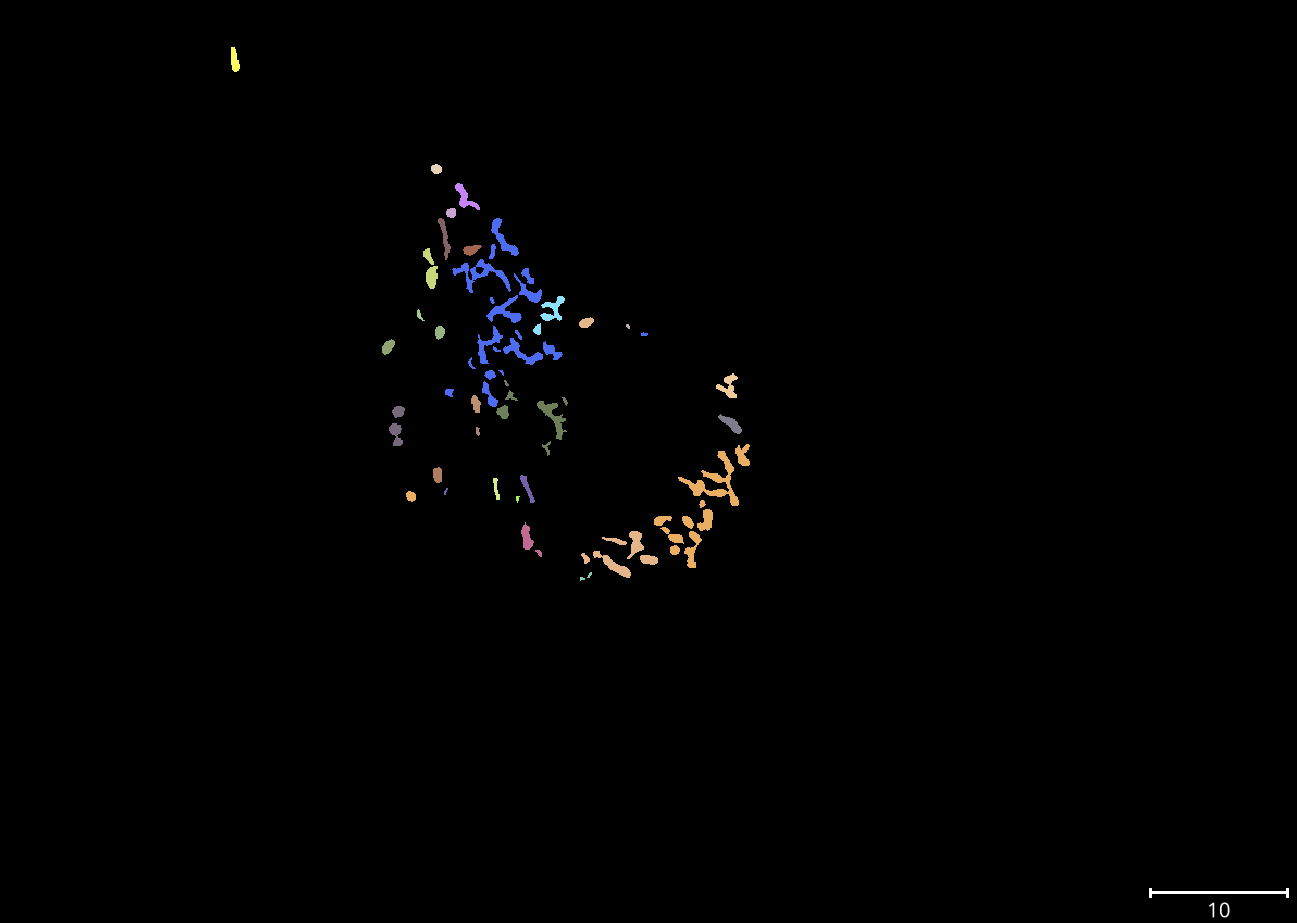

In [42]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [43]:
viewer.close()

-------------
## SUMMARY

The above details how the mitochondria object is inferred.  

### NEXT: INFER GOLGI

proceed to [06_infer_golgi.ipynb](./06_infer_golgi.ipynb)
